In [4]:
import matplotlib.pyplot as plt
import numpy as np
import mynn as nn

def visualize_conv_filters(model, save_path=None):
    """
    可视化CNN模型中所有卷积层的权重
    Args:
        model: 加载的CNN模型
        save_path: 可视化结果保存路径（可选）
    """
   
    conv_layers = []
    for idx, layer in enumerate(model.layers):
        if isinstance(layer, nn.op.conv2D):
            conv_layers.append( (idx, layer) )
    
    if not conv_layers:
        print("模型中未找到卷积层")
        return

   
    for layer_idx, layer in conv_layers:
        filters = layer.W  
        num_filters = filters.shape[0]
        in_channels = filters.shape[1]
        k = filters.shape[2]            # 卷积核尺寸
        
       
        cols = 8 if num_filters >= 8 else num_filters
        rows = int(np.ceil(num_filters / cols))
        
        
        fig = plt.figure(figsize=(cols*1.5, rows*1.5))
        plt.suptitle(f"Conv Layer {layer_idx} Filters\nShape: {filters.shape}", y=1.02)
        
        
        for i in range(num_filters):
            ax = fig.add_subplot(rows, cols, i+1)
            
            
            kernel = filters[i]
            
            
            if in_channels == 1:
                img = kernel[0]
                cmap = 'gray'
            else:
                # 多通道
                img = np.mean(kernel, axis=0)
                cmap = 'viridis'
            
            ax.imshow(img, cmap=cmap)
            ax.axis('off')
            ax.set_title(f"Filter {i}", fontsize=8)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(f"{save_path}_layer{layer_idx}.png", bbox_inches='tight', dpi=150)
            print(f"卷积层{layer_idx}可视化结果已保存至：{save_path}_layer{layer_idx}.png")
        else:
            plt.show()
        plt.close()


In [5]:
# 加载模型
model = nn.models.Model_CNN()
model.load_model(r'.\saved_models\best_model_CNNwithpoolanddropout0_2.pickle')

visualize_conv_filters(model, save_path="./conv_filters_vis")

卷积层0可视化结果已保存至：./conv_filters_vis_layer0.png
卷积层2可视化结果已保存至：./conv_filters_vis_layer2.png



=== CNN数据预处理验证 ===
训练集图像形状: (50000, 1, 28, 28) (样本数, 通道数, 高, 宽)
单个样本形状: (1, 28, 28)
训练集标签形状: (50000,)
验证集图像形状: (320, 1, 28, 28)
像素值范围: [0.0, 1.0]


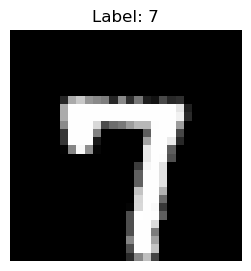

In [6]:
import gzip
import numpy as np
from struct import unpack
import pickle
import mynn as nn

# 固定随机种子
np.random.seed(309)

# 数据路径
train_images_path = r'.\dataset\MNIST\train-images-idx3-ubyte.gz'
train_labels_path = r'.\dataset\MNIST\train-labels-idx1-ubyte.gz'

# 加载图像数据
with gzip.open(train_images_path, 'rb') as f:
    magic, num, rows, cols = unpack('>4I', f.read(16))
    train_imgs = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)  # shape (60000, 28, 28)
    train_imgs = train_imgs[:, np.newaxis, :, :]  # 最终shape (60000, 1, 28, 28)

# 加载标签数据
with gzip.open(train_labels_path, 'rb') as f:
    magic, num = unpack('>2I', f.read(8))
    train_labs = np.frombuffer(f.read(), dtype=np.uint8)

# 数据划分
idx = np.random.permutation(np.arange(num))
train_imgs = train_imgs[idx]
train_labs = train_labs[idx]
valid_imgs = train_imgs[:320]
valid_labs = train_labs[:320]
train_imgs = train_imgs[10000:]
train_labs = train_labs[10000:]

# 归一化
train_imgs = train_imgs / 255.0  
valid_imgs = valid_imgs / 255.0


print("\n=== CNN数据预处理验证 ===")
print(f"训练集图像形状: {train_imgs.shape} (样本数, 通道数, 高, 宽)")
print(f"单个样本形状: {train_imgs[0].shape}")
print(f"训练集标签形状: {train_labs.shape}")
print(f"验证集图像形状: {valid_imgs.shape}")
print(f"像素值范围: [{train_imgs.min()}, {train_imgs.max()}]")

# 可视化第一个样本
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
plt.imshow(train_imgs[0][0], cmap='gray')  
plt.title(f"Label: {train_labs[0]}")
plt.axis('off')
plt.show()

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_layer_output(model, sample_img, layer_indices=[0, 2]):
  
    if sample_img.ndim == 3:
        sample_img = sample_img[np.newaxis, ...]

    # 前向传播并记录中间层输出
    activations = []
    x = sample_img.copy()
    for idx, layer in enumerate(model.layers):
        x = layer(x)
        if idx in layer_indices and isinstance(layer, (nn.op.conv2D, nn.op.max_pool)):
            activations.append((idx, x))
        if isinstance(layer, nn.op.Flatten):
            break  

    # 可视化各层激活图
    plt.figure(figsize=(16, 10))  
    for i, (layer_idx, feat_maps) in enumerate(activations):
        num_feat = feat_maps.shape[1]  
        print(f"Layer {layer_idx} 输出形状: {feat_maps.shape}")

      
        cols = min(8, num_feat)
        rows = (num_feat // 8) + (1 if num_feat % 8 != 0 else 0)

       
        ax_index = i + 2  
        plt.subplot(rows, cols, ax_index)

        for j in range(min(16, num_feat)):
            ax = plt.subplot(rows, cols, j + 1)
            ax.imshow(feat_maps[0, j], cmap='viridis')  
            ax.set_title(f"Ch{j}", fontsize=6)
            ax.axis('off')

        plt.suptitle(f"Layer {layer_idx} Activation Maps", y=0.8)

    
    plt.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)  # 调整子图间的间距
    plt.show()

可视化样本标签: 7
Layer 0 输出形状: (1, 6, 28, 28)


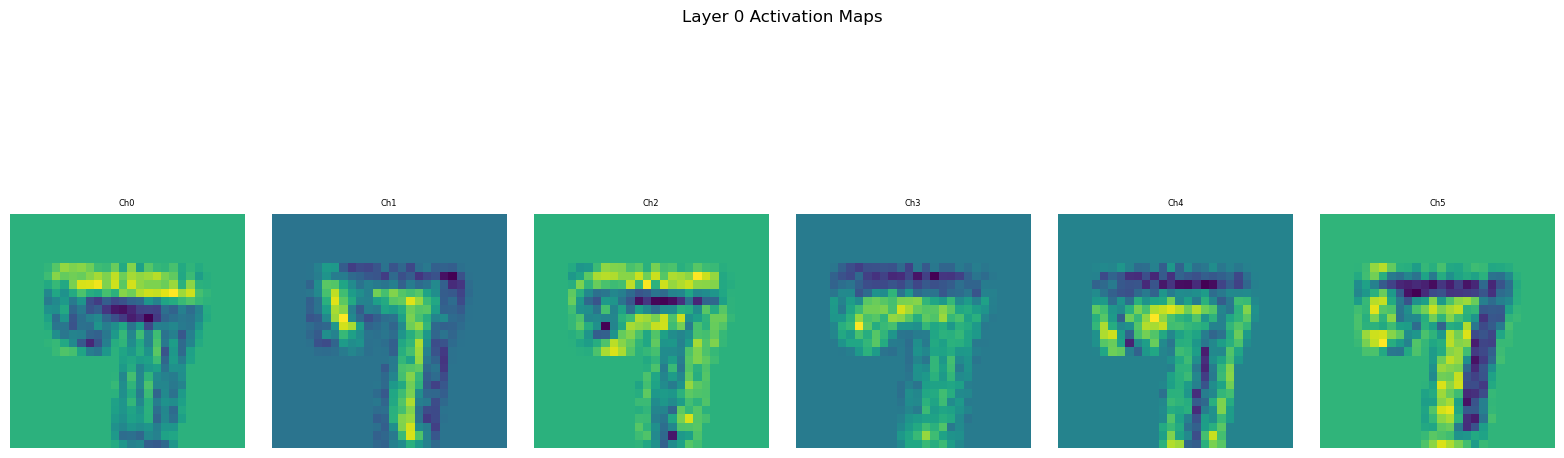

In [8]:
# 加载模型
model=nn.models.Model_CNN()
model.load_model(r'.\saved_models\best_model_CNNwithpoolanddropout0_2.pickle')
    

sample_idx = 0
sample_img = train_imgs[sample_idx][np.newaxis, ...]  # 添加batch维度 -> [1,1,28,28]
sample_label = train_labs[sample_idx]
    
print(f"可视化样本标签: {sample_label}")
    
# 可视化第一个卷积层
visualize_layer_output(model, sample_img, layer_indices=[0])

Layer 2 输出形状: (1, 16, 12, 12)


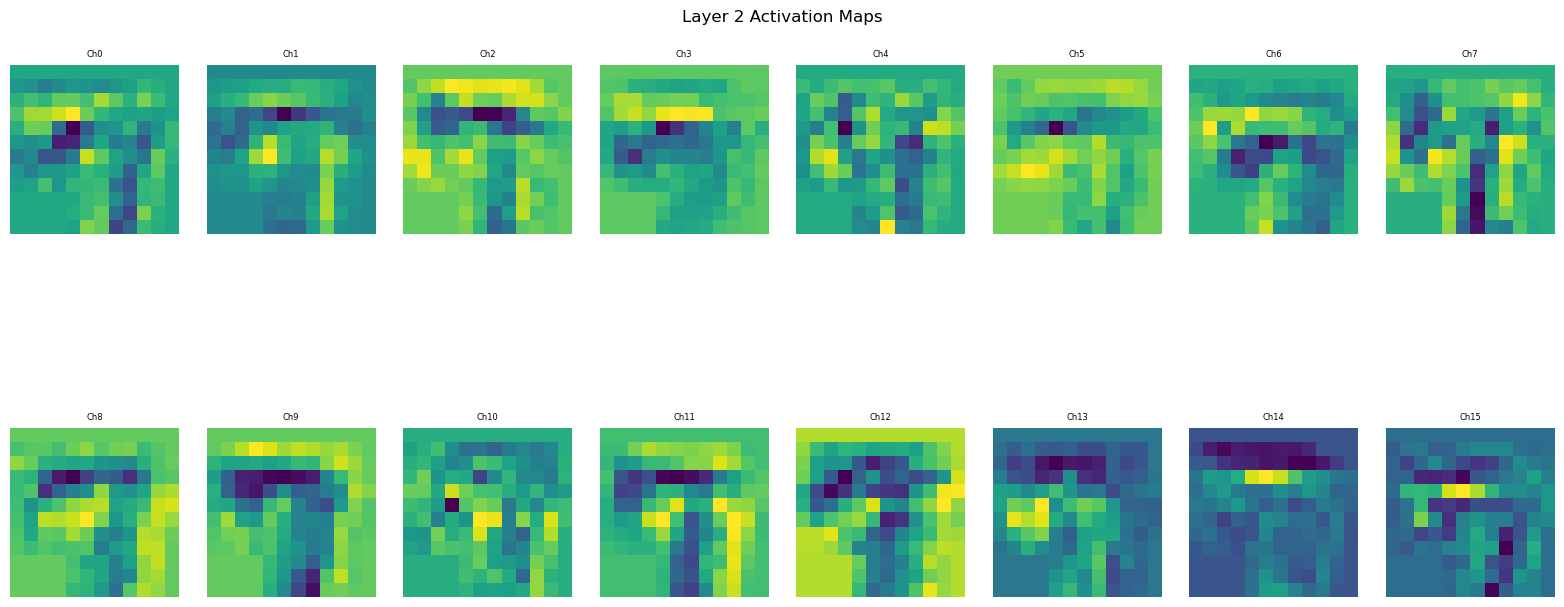

In [9]:
# 可视化第三个卷积层
visualize_layer_output(model, sample_img, layer_indices=[2])